# CDMS Match Up Demo
Cloud-based Data Matchup Service (CDMS) allows users to collocate satellite to in-situ and satellite to satellite data. 

In this notebook, the match-up feature will be demonstrated.

In [1]:
import requests
import json
from urllib.parse import urljoin, urlencode

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D

In [2]:
matchup_url = 'https://doms.jpl.nasa.gov/match_spark'

In [3]:
def execute_matchup_request(query_params):
    full_matchup_url = f'{matchup_url}?{urlencode(query_params)}'
    print(full_matchup_url)
    
    response = requests.get(full_matchup_url)
    response = response.json()
#     print(json.dumps(response, indent=2))
    
    primary_points = [(float(primary_point['x']), float(primary_point['y']), float(primary_point['primary'][0]['variable_value'])) for primary_point in response['data']]
    secondary_points = [(float(secondary_point['x']), float(secondary_point['y']), float(secondary_point['secondary'][0]['variable_value'])) for primary_point in response['data'] for secondary_point in primary_point['matches']]
    return primary_points, secondary_points

In [4]:
query_params = {
    'primary': 'MUR25-JPL-L4-GLOB-v04.2',
    'secondary': 'icoads',
    'startTime': '2018-09-24T00:00:00Z',
    'endTime': '2018-09-30T00:00:00Z',
    'tt': 2592000,  # Time tolerance
    'rt': 1000,  # Spatial tolerance
    'b': '160,-30,180,-25',
    'platforms': '1,2,3,4,5,6,7,8,9',
    'depthMin': 0,
    'depthMax': 5,
    'matchOnce': 'true',
    'resultSizeLimit': 100
}

In [5]:
primary_points, secondary_points = execute_matchup_request(query_params)

https://doms.jpl.nasa.gov/match_spark?primary=MUR25-JPL-L4-GLOB-v04.2&secondary=icoads&startTime=2018-09-24T00%3A00%3A00Z&endTime=2018-09-30T00%3A00%3A00Z&tt=2592000&rt=1000&b=160%2C-30%2C180%2C-25&platforms=1%2C2%2C3%2C4%2C5%2C6%2C7%2C8%2C9&depthMin=0&depthMax=5&matchOnce=true&resultSizeLimit=100


In [6]:
def plot_points(primary_points, secondary_points):
    plt.figure(figsize=(20,5), dpi=500) 
    min_lon = min([point[0] for point in primary_points])
    max_lon = max([point[0] for point in primary_points])
    min_lat = min([point[1] for point in primary_points])
    max_lat = min([point[1] for point in primary_points])
    basemap = Basemap(
        projection='mill',
        lon_0=180,
        llcrnrlat=min_lat - 10,
        urcrnrlat=max_lat + 10,
        llcrnrlon=min_lon - 10,
        urcrnrlon=max_lon + 10
    )
    basemap.drawlsmask(
        land_color='lightgrey',
        ocean_color='white',
        lakes=True
    )

    # transform coordinates
    x1, y1 = basemap([point[0] for point in primary_points], [point[1] for point in primary_points])  
    x2, y2 = basemap([point[0] for point in secondary_points], [point[1] for point in secondary_points])
    
    # Draw scatter points
    plt.scatter(x2, y2, 10, marker='o', color='Blue', label='Primary point')
    plt.scatter(x1, y1, 10, marker='*', color='Green', label='Secondary point')

    # transform input bbox
    bx, by = basemap([160, 180], [-25, -30])  
    
    # Draw user provided bounds
    plt.gca().add_patch(patches.Rectangle(
        (bx[0], by[1]), abs(bx[0] - bx[1]), abs(by[0] - by[1]), 
        linewidth=1, 
        edgecolor='r', 
        facecolor='none'
    ))
    
    # Show legend
    handles, labels = plt.gca().get_legend_handles_labels()
    bbox_legend = Line2D(
        [0], [0], 
        color='red', 
        linewidth=1, 
        linestyle='-', 
        label='User search domain'
    )
    handles.append(bbox_legend)
    plt.legend(loc='upper left', handles=handles)
    
    plt.show()

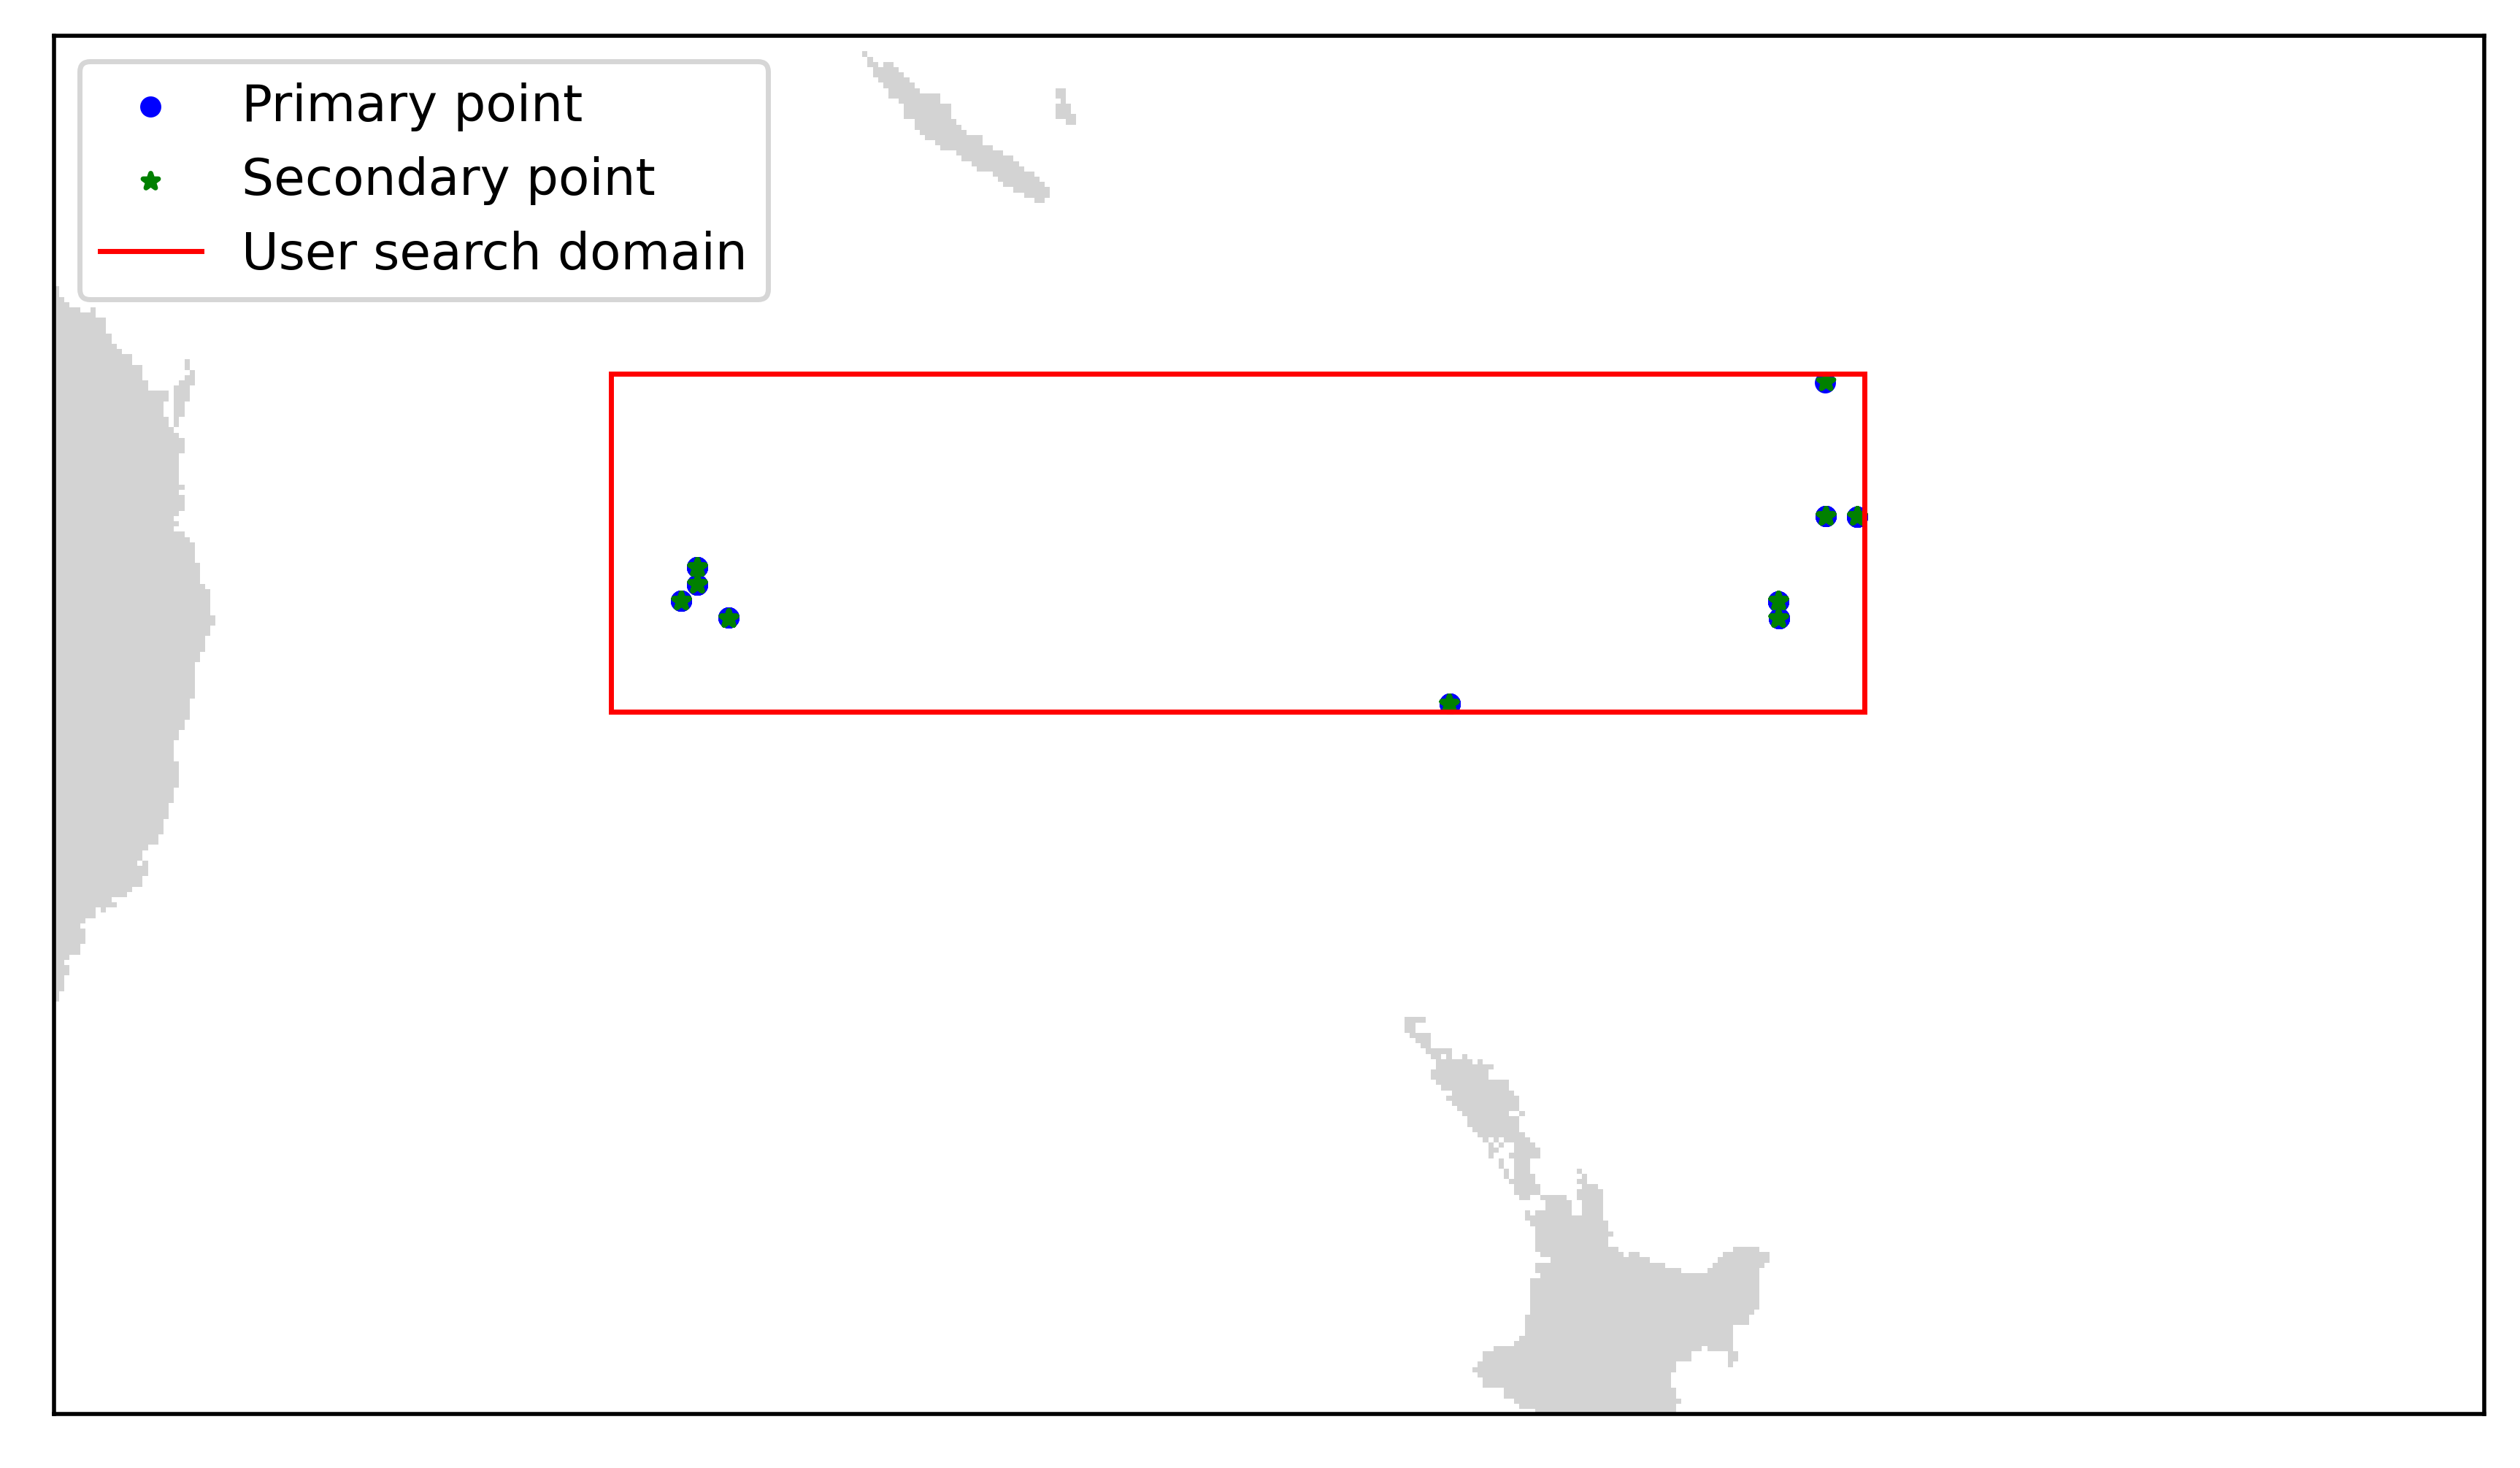

In [7]:
plot_points(primary_points, secondary_points)

In [8]:
def generate_diff_plot(primary_points, secondary_points, primary_name, secondary_name):
    diffs = [primary_point[2] - secondary_point[2] for primary_point, secondary_point in zip(primary_points, secondary_points)]
    
    plt.figure(figsize=(20,5), dpi=500) 
    min_lon = min([point[0] for point in primary_points])
    max_lon = max([point[0] for point in primary_points])
    min_lat = min([point[1] for point in primary_points])
    max_lat = min([point[1] for point in primary_points])
    basemap = Basemap(
        projection='mill',
        lon_0=180,
        llcrnrlat=min_lat - 10,
        urcrnrlat=max_lat + 10,
        llcrnrlon=min_lon - 10,
        urcrnrlon=max_lon + 10
    )
    basemap.drawlsmask(
        land_color='lightgrey',
        ocean_color='white',
        lakes=True
    )

    # transform coordinates
    x1, y1 = basemap([point[0] for point in primary_points], [point[1] for point in primary_points])  
    x2, y2 = basemap([point[0] for point in secondary_points], [point[1] for point in secondary_points])
    
    # Customize colormap/colorbar
    cmap = plt.cm.coolwarm
    # Draw scatter points
    sc = plt.scatter(x2, y2, 30, marker='o', c=diffs, alpha=0.7, cmap=cmap)

    # transform input bbox
    bx, by = basemap([160, 180], [-25, -30])  
    
    cb = plt.colorbar(sc)
    cb.ax.set_title('°C',fontsize=8)        
    plt.title(f'Difference plot between {primary_name} and {secondary_name}')

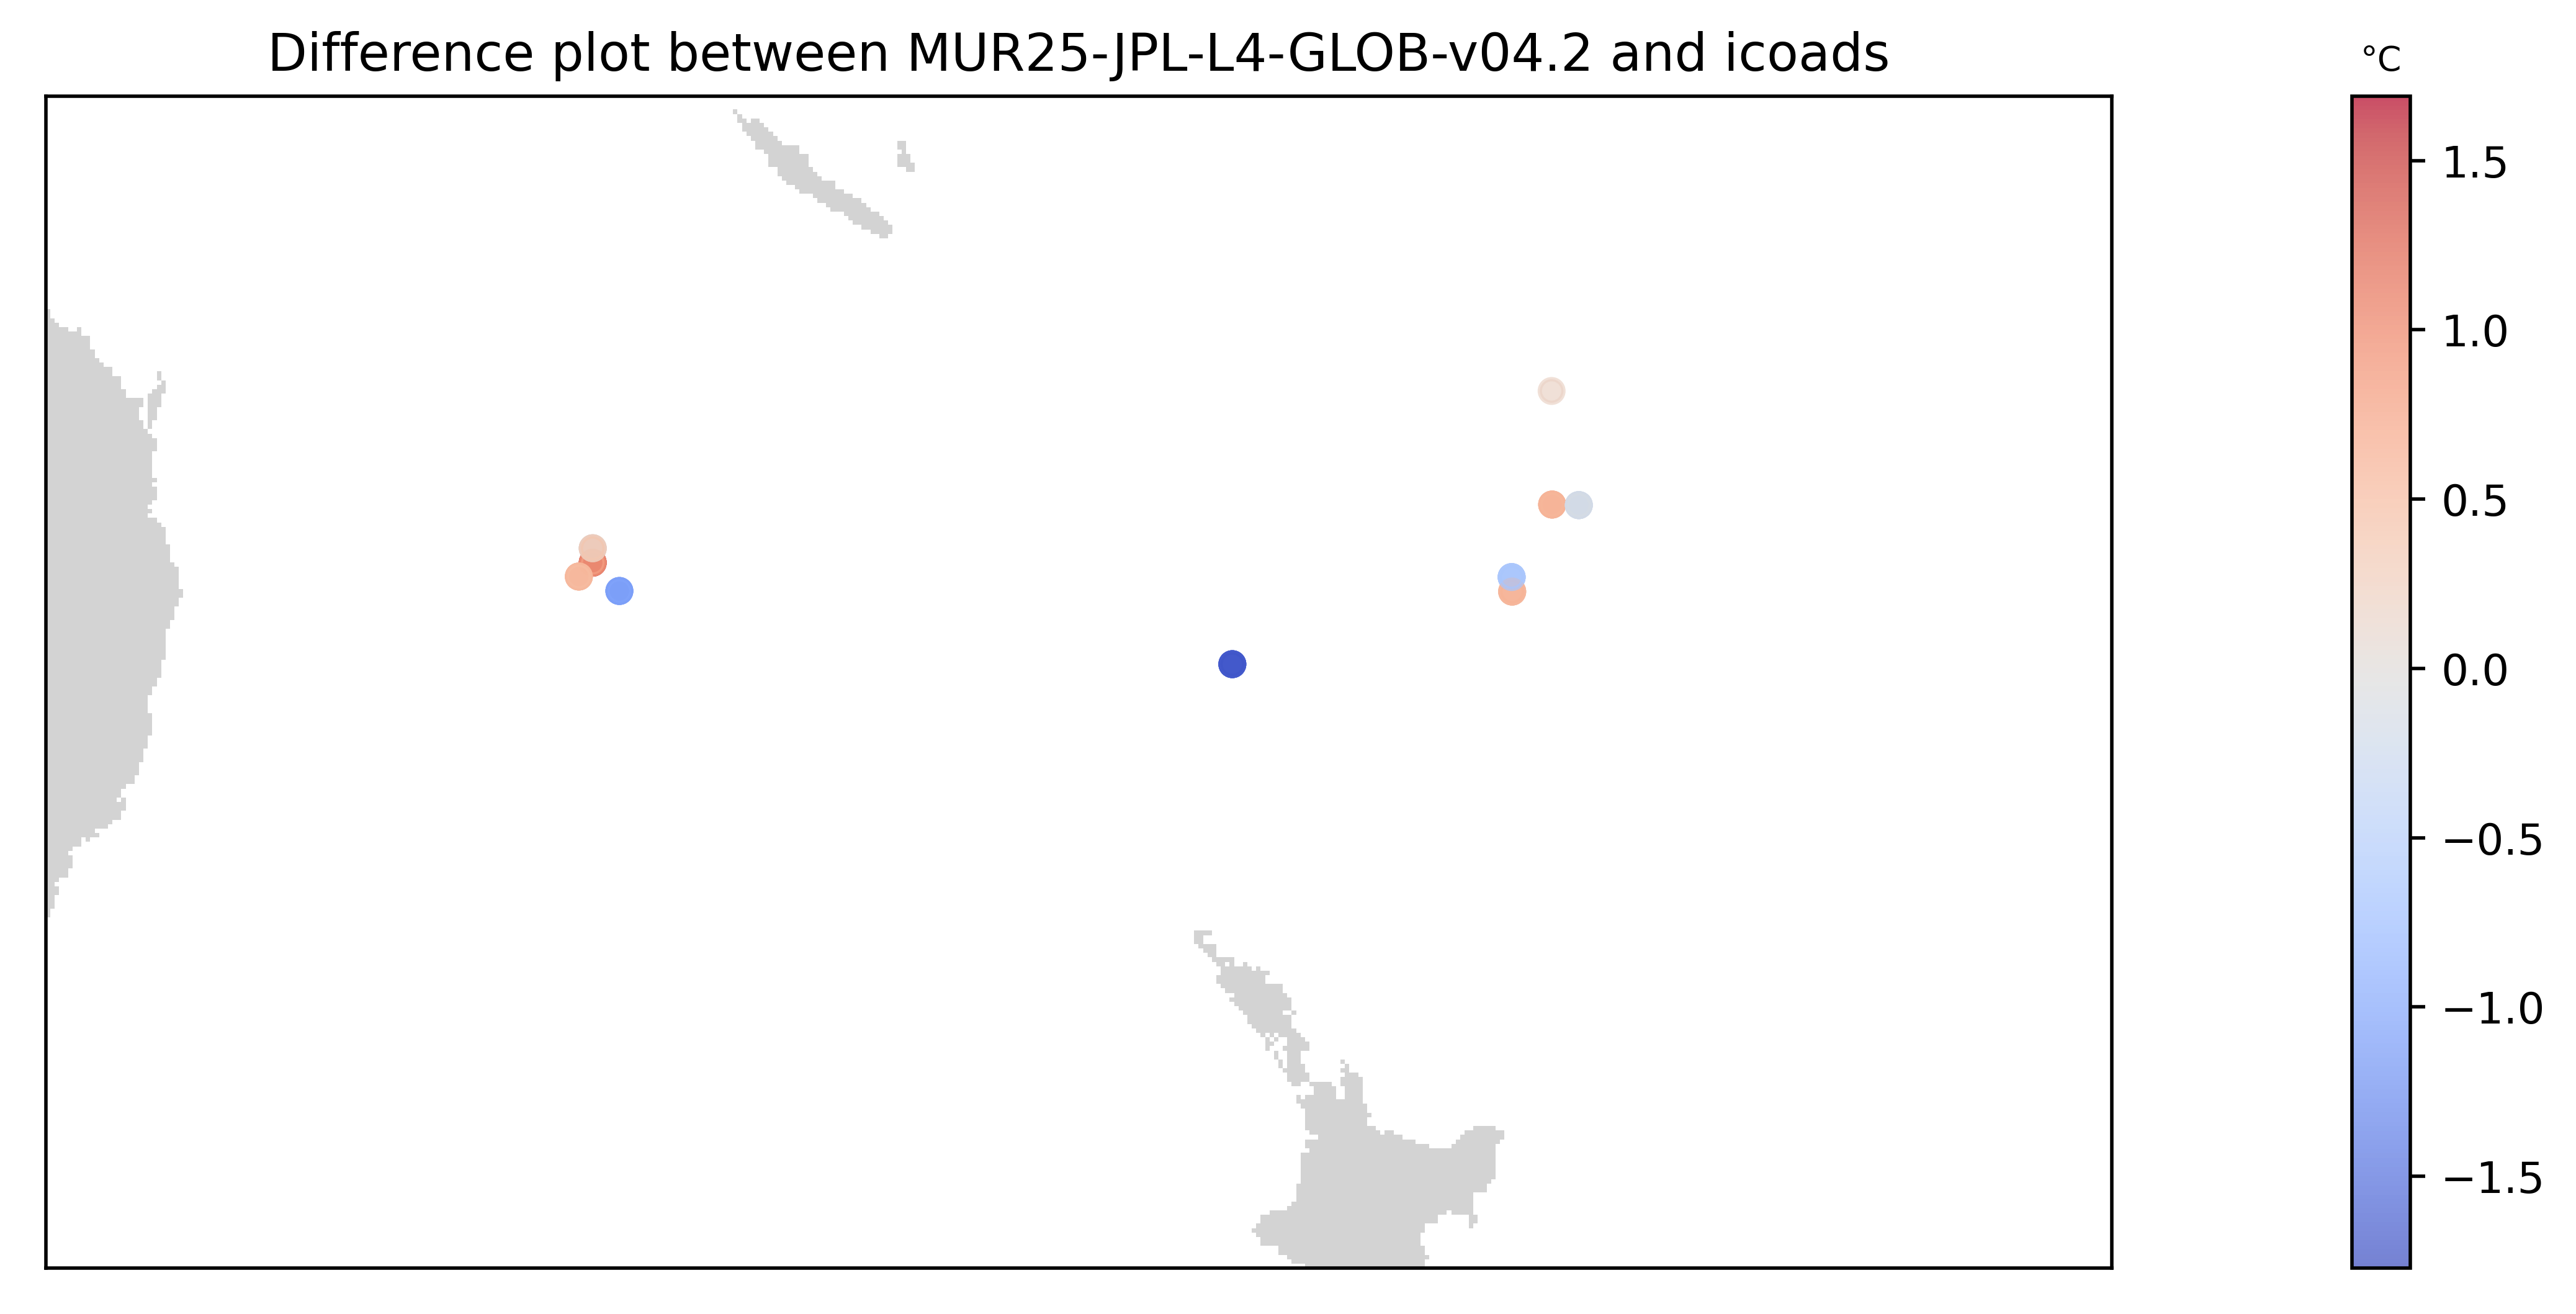

In [9]:
generate_diff_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'])

https://doms.jpl.nasa.gov/match_spark?primary=MUR25-JPL-L4-GLOB-v04.2&secondary=spurs2&startTime=2017-03-01T00%3A00%3A00Z&endTime=2017-03-30T00%3A00%3A00Z&tt=2592000&rt=10000&b=-120%2C15%2C-90%2C55&platforms=1%2C2%2C3%2C4%2C5%2C6%2C7%2C8%2C9&depthMin=0&depthMax=5&matchOnce=true&resultSizeLimit=1000


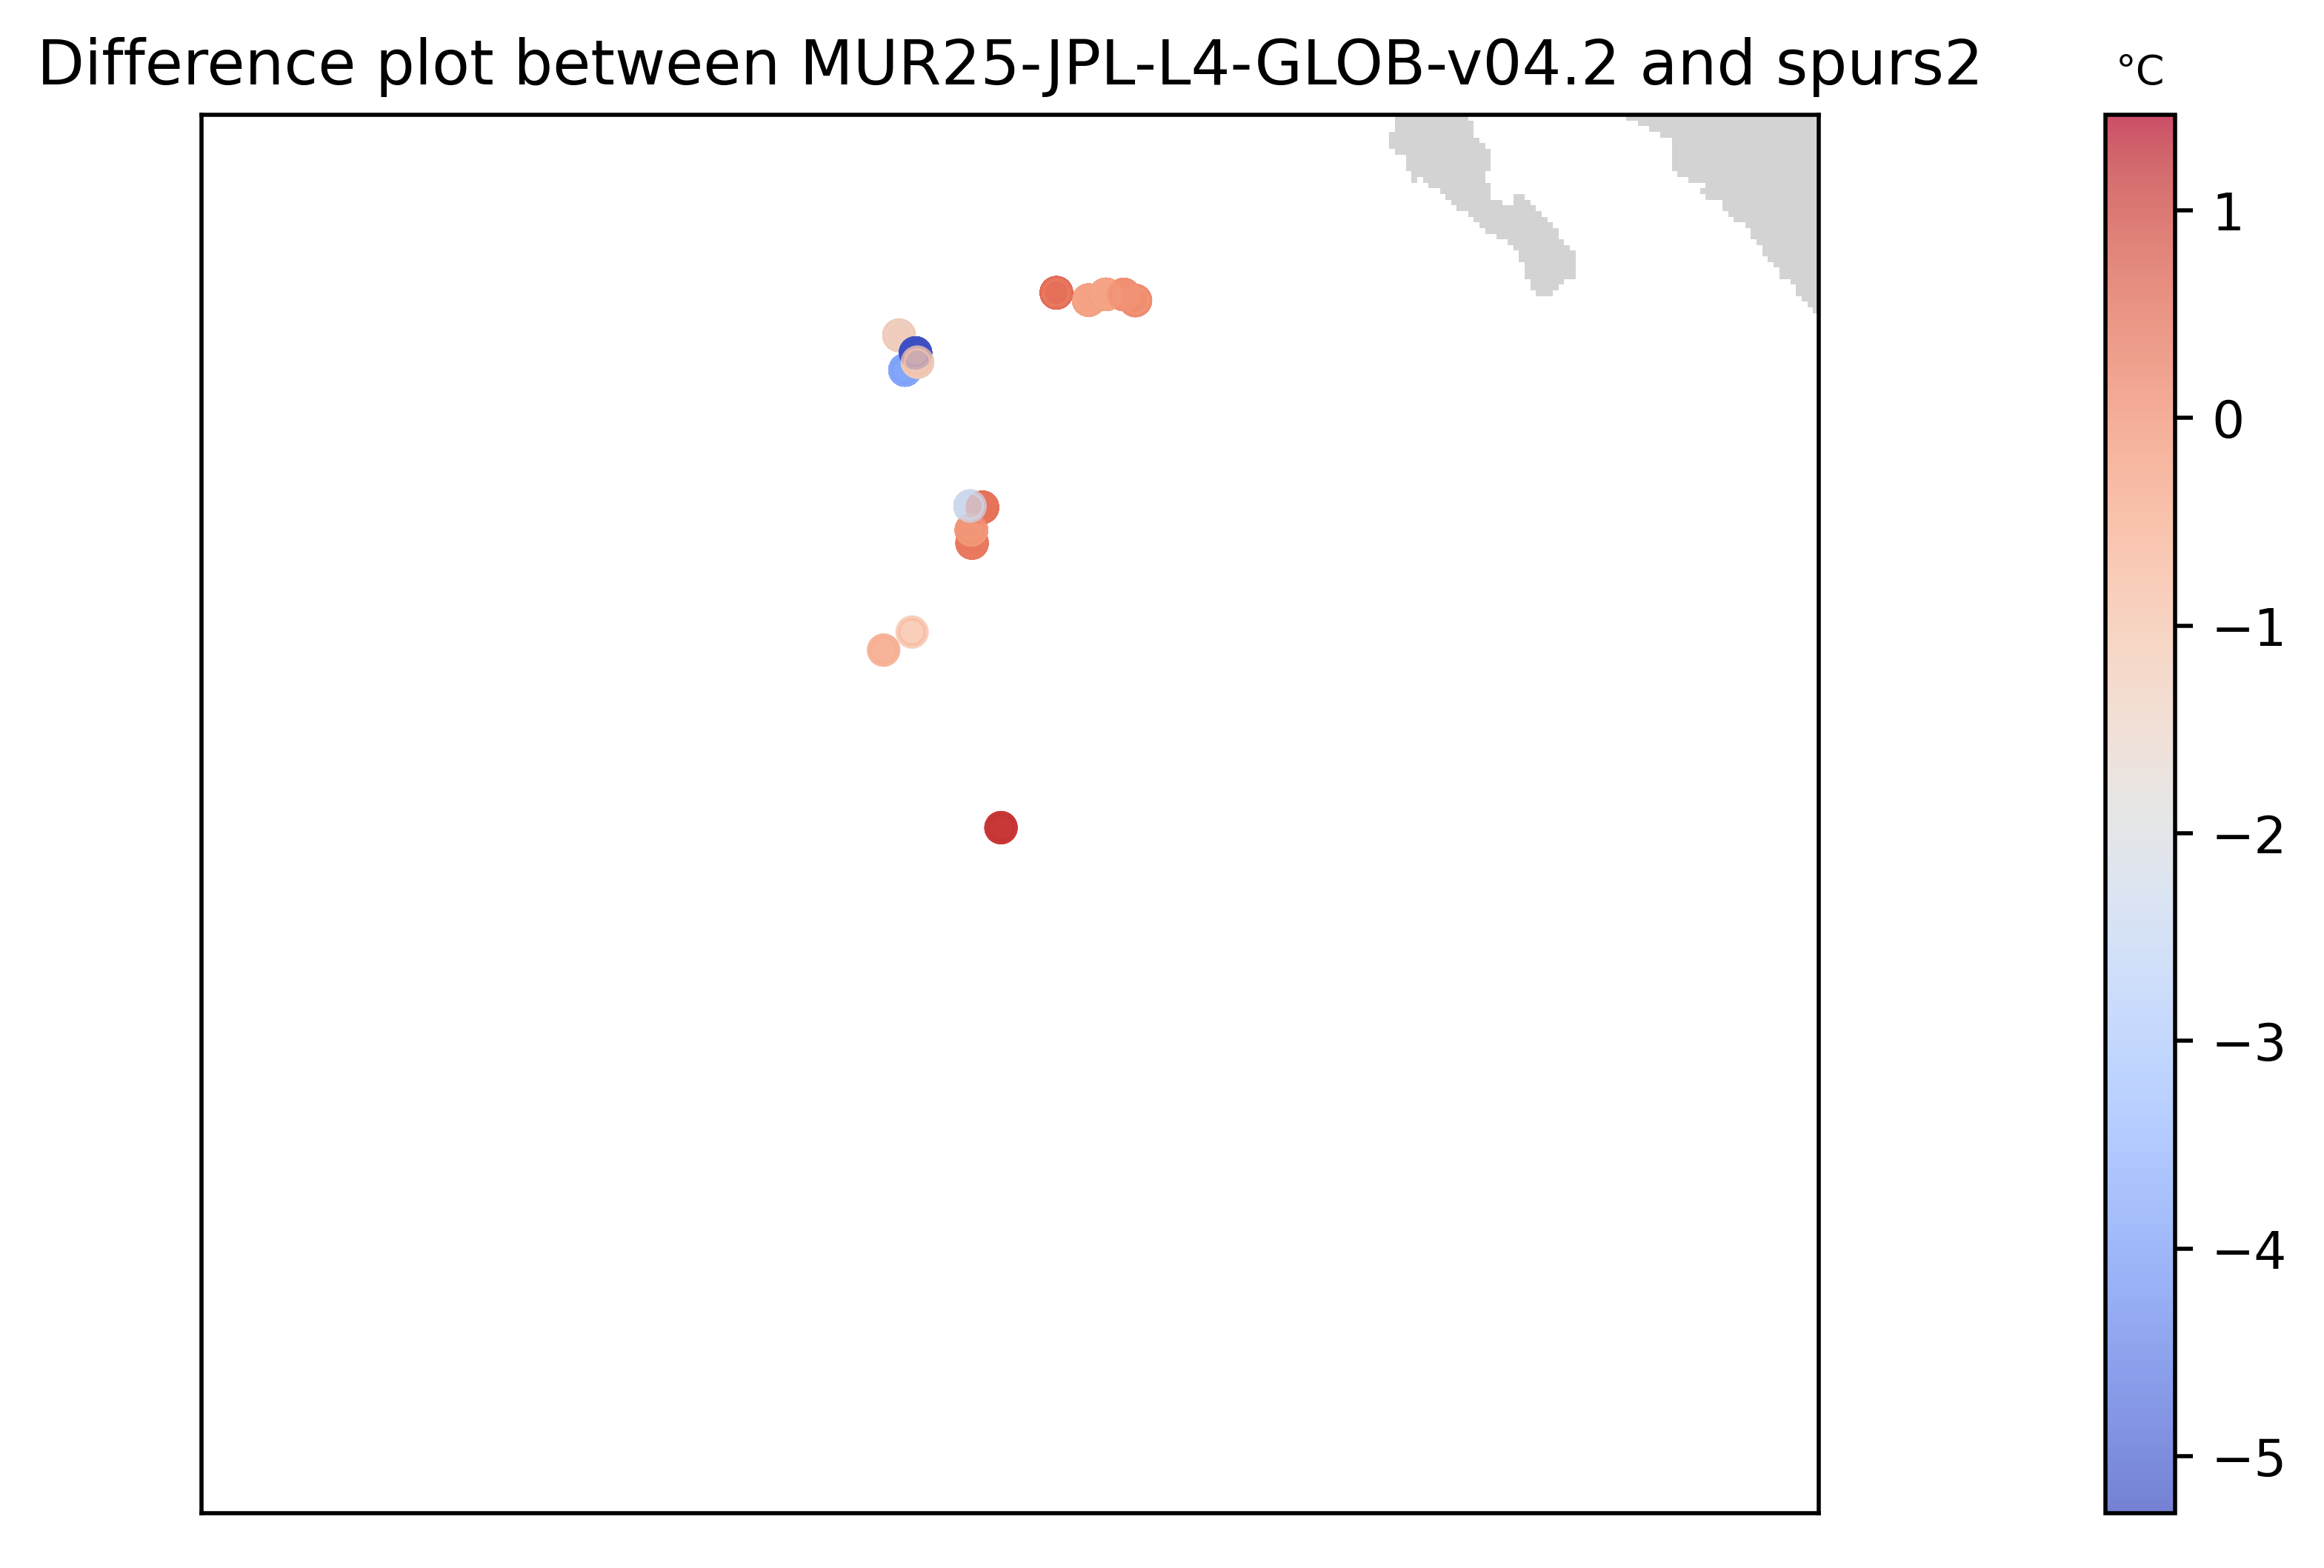

In [10]:
query_params = {
    'primary': 'MUR25-JPL-L4-GLOB-v04.2',
    'secondary': 'spurs2',
    'startTime': '2017-03-01T00:00:00Z',
    'endTime': '2017-03-30T00:00:00Z',
    'tt': 2592000,  # Time tolerance
    'rt': 10000,  # Spatial tolerance
    'b': '-120,15,-90,55',
    'platforms': '1,2,3,4,5,6,7,8,9',
    'depthMin': 0,
    'depthMax': 5,
    'matchOnce': 'true',
    'resultSizeLimit': 1000
}

primary_points, secondary_points = execute_matchup_request(query_params)
generate_diff_plot(primary_points, secondary_points, query_params['primary'], query_params['secondary'])